# ConvNet Transfer training

> Training multiple ConvNets against the ImageNette dataset.
>
> ©2020 Spencer Woo - https://github.com/spencerwooo

## Target

Transfer training **ResNet18, VGG11, MobileNet v2** with ImageNet pretrained weights on ImageNette dataset (outputs 10 class_names)

- Download dataset here: [ImageNette](https://github.com/fastai/imagenette)
- Unzip downloaded dataset under path `./data`, with the following hierarchy:
  
  ```
  .
  ├── imagenette2-160
  │   ├── train
  │   └── val
  └── imagenette2-160.tar

  3 directories, 1 file
  ```

- Please run inside Jupyter Notebook/Lab with IPyWidgets installed for better experience

## Saved model

Trained model's state dict are saved inside children folders in the format of: 

```
{model_name}_foolbox/{date_and_time}_{model_name}_imagenette.pth
```

In [3]:
from __future__ import division, print_function

import copy
import os
import time
import urllib
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from halo import HaloNotebook as Halo

from utils import trainer

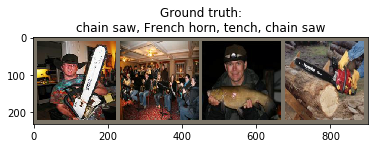

In [4]:
# utilize gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define class names
class_names = [
    'tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump',
    'golf ball', 'parachute'
]

# path to dataset
dataset_path = './data/imagenette2-160'
data_loaders, data_sizes = trainer.import_dataset(dataset_path)

# preview images from training set
inputs, labels = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs, padding=10)
trainer.preview_images(out, img_title=[class_names[x] for x in labels])

In [22]:
# Train ConvNets as a fixed feature extractor
# See here: https://cs231n.github.io/transfer-learning for different types of ways to performing transfer learning

# CNN model to load: ['resnet18', 'vgg11', 'inception_v3', 'mobilenet_v2']
target_cnn = 'mobilenet_v2'

# load CNN
spinner = Halo(text='Preparing ConvNet: {}'.format(target_cnn), spinner='dots')
spinner.start()
model_conv, top_layer = trainer.load_pretrained_model(target_cnn, class_names)

# push model to GPU
model_conv = model_conv.to(device)
spinner.succeed('Loaded!')
# TO-DO: fix spinner output disappearing when referred once only
spinner.start()
spinner.stop()

# define criterion, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(top_layer.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer_conv, step_size=7, gamma=0.1)

Output()

Output()

In [6]:
# Train and evaluate model

# set number of epochs
model_epoches = 10
# start training!
model_conv, loss, acc = trainer.train_model(device,
                                            data_loaders,
                                            data_sizes,
                                            model_conv,
                                            criterion,
                                            optimizer_conv,
                                            exp_lr_scheduler,
                                            epoches=model_epoches)

# model directory names
MODEL_DIR = {
    'resnet18': 'resnet_foolbox',
    'vgg11': 'vgg_foolbox',
    'inception_v3': 'inception_foolbox',
    'mobilenet_v2': 'mobilenet_foolbox'
}

# save trained model
now = datetime.now()
MODEL_PATH = '{}/{}_{}_imagenette.pth'.format(MODEL_DIR[target_cnn], now.strftime('%y%m%d_%H%M'), target_cnn)
torch.save(model_conv.state_dict(), MODEL_PATH)

Epoch: 10/10 -   val: 100%|██████████| 982/982 [00:17<00:00, 55.23it/s, loss=0.00%]



Training completed in 13m 48s
Best validation accuracy: 97.019108 %


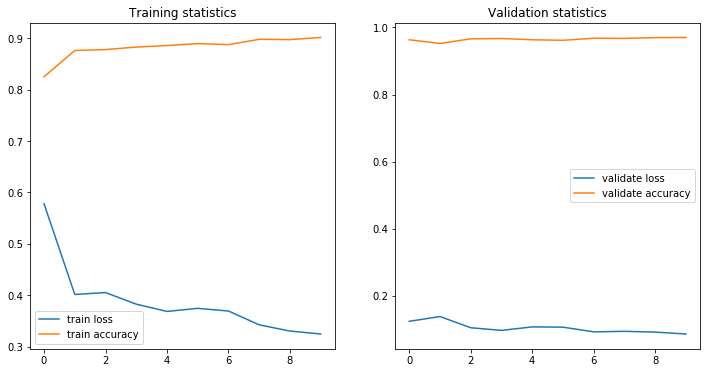

In [7]:
# plot loss and acc
x = np.arange(0, model_epoches)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(x, loss['train'], label='train loss')
plt.plot(x, acc['train'], label='train accuracy')
plt.title('Training statistics')
plt.legend()

plt.subplot(122)
plt.plot(x, loss['val'], label='validate loss')
plt.plot(x, acc['val'], label='validate accuracy')
plt.title('Validation statistics')
plt.legend()
plt.show()